In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
        filtered_cv_results['momentum'] = pd.Categorical(filtered_cv_results['momentum'], 
                                                         ['none', 'standard', 'nesterov'])
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'n_iter', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 'mean_train_n_iter', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [7]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [8]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


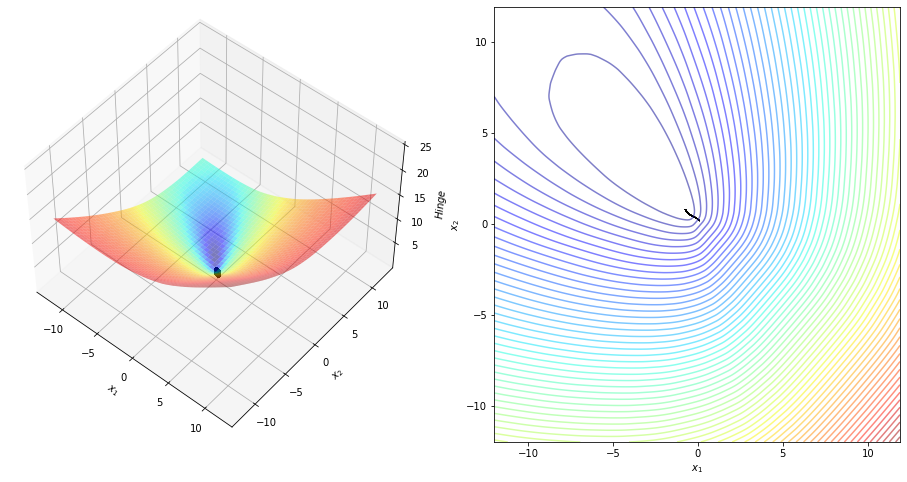

In [9]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum=0.4, batch_size=20, early_stopping=True),
                    param_grid={'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [10]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svc_hinge_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
custom_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.614727    2222        0.987525      0.985075   
           standard  0.386092    1417        0.987525      0.985075   
           nesterov  0.396583    1368        0.985019      0.980100   
       10  none      1.435118    4602        0.990012      0.980100   
           standard  1.195032    4068        0.987506      0.985075   
           nesterov  1.120775    3940        0.992500      0.985075   
       100 none      0.505901    1919        0.990012      0.985075   
           standard  0.292062     911        0.990012      0.985075   
           nesterov  0.286854    1060        0.990012      0.985075   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              38        21  
           standard          36        20  
           nesterov          34        20  
       10  none              13         7  
           standard          12         7  
           nesterov          12         7  
       100 none               5         3  
           standard           6         4  
           nesterov           5         3

In [11]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [12]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001517     146        0.979969      0.979798   
          10  -         0.001479     397        0.982475      0.984848   
          100 -         0.002547    1000        0.979950      0.984924   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 11         5  
          10  -                  7         5  
          100 -                  6         4

In [13]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.614727    2222        0.987525      0.985075   
              standard  0.386092    1417        0.987525      0.985075   
              nesterov  0.396583    1368        0.985019      0.980100   
          10  none      1.435118    4602        0.990012      0.980100   
              standard  1.195032    4068        0.987506      0.985075   
              nesterov  1.120775    3940        0.992500      0.985075   
          100 none      0.505901    1919        0.990012      0.985075   
              standard  0.292062     911        0.990012      0.985075   
              nesterov  0.286854    1060        0.990012      0.985075   
liblinear 1   -         0.001517     146        0.979969      0.979798   
          10  -         0.001479     397        0.982475      0.984848   
          100 -         0.002547    1000        0.979950      0.984924   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              38        21  
              standard          36        20  
              nesterov          34        20  
          10  none              13         7  
              standard          12         7  
              nesterov          12         7  
          100 none               5         3  
              standard           6         4  
              nesterov           5         3  
liblinear 1   -                 11         5  
          10  -                  7         5  
          100 -                  6         4

### Dual formulations

In [13]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [14]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [15]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1, 
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


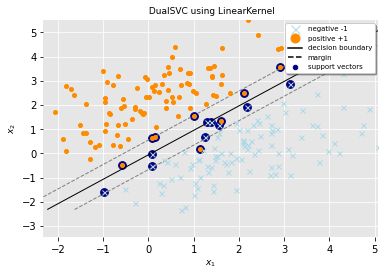

In [16]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [17]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
cvxopt 1    0.022609      10        0.987525      0.974974          12   
       10   0.017216      10        0.987525      0.974974           9   
       100  0.031388      10        0.982512      0.974974           7   
smo    1    0.094136     105        0.987525      0.974974          12   
       10   0.121012     144        0.987525      0.974974           8   
       100  0.660060    2050        0.982512      0.974974           7   

            val_n_sv  
solver C              
cvxopt 1          12  
       10          9  
       100         7  
smo    1          12  
       10          8  
       100         7

In [18]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [19]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
libsvm 1    0.002635     257        0.982512      0.970074          14   
       10   0.004053     522        0.982512      0.965099           9   
       100  0.003277    3866        0.985019      0.955073           7   

            val_n_sv  
solver C              
libsvm 1          14  
       10          9  
       100         7

In [20]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
cvxopt 1    0.022609      10        0.987525      0.974974          12   
       10   0.017216      10        0.987525      0.974974           9   
       100  0.031388      10        0.982512      0.974974           7   
smo    1    0.094136     105        0.987525      0.974974          12   
       10   0.121012     144        0.987525      0.974974           8   
       100  0.660060    2050        0.982512      0.974974           7   
libsvm 1    0.002635     257        0.982512      0.970074          14   
       10   0.004053     522        0.982512      0.965099           9   
       100  0.003277    3866        0.985019      0.955073           7   

            val_n_sv  
solver C              
cvxopt 1          12  
       10          9  
       100         7  
smo    1          12  
       10          8  
       100         7  
libsvm 1          14  
       10          9  
       100         7

##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


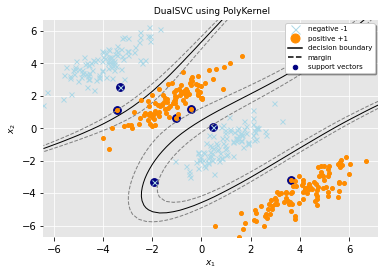

In [21]:
X, y = generate_nonlinearly_separable_data(random_state=2)

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [22]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.092079      10        0.832507      0.675831          32   
              10   0.111197      10        0.956159      0.830734          11   
              100  0.097903      10        0.993734      0.985056           8   
smo    poly   1    0.391564     137        0.831259      0.675831          32   
              10   0.311969     141        0.948640      0.810852          11   
              100  0.293261     241        0.993734      0.987562           8   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          32  
              10         11  
              100         8  
smo    poly   1          32  
              10         11  
              100         8

Fitting 3 folds for each of 6 candidates, totalling 18 fits


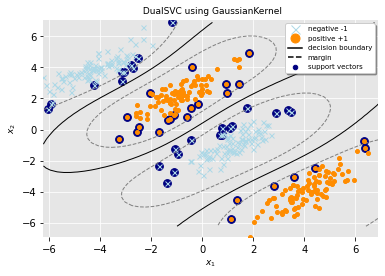

In [23]:
X, y = generate_nonlinearly_separable_data(random_state=2)

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [24]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt rbf    1    0.072104      10        0.998747      1.000000          48   
              10   0.069883      10        1.000000      0.997494          16   
              100  0.077572      10        1.000000      0.997494          12   
smo    rbf    1    0.253831      38        0.998747      1.000000          44   
              10   0.234757      39        1.000000      0.997494          15   
              100  0.164737      47        1.000000      0.997494          11   

                   val_n_sv  
solver kernel C              
cvxopt rbf    1          48  
              10         16  
              100        12  
smo    rbf    1          44  
              10         15  
              100        11

In [25]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.092079      10        0.832507      0.675831          32   
              10   0.111197      10        0.956159      0.830734          11   
              100  0.097903      10        0.993734      0.985056           8   
       rbf    1    0.072104      10        0.998747      1.000000          48   
              10   0.069883      10        1.000000      0.997494          16   
              100  0.077572      10        1.000000      0.997494          12   
smo    poly   1    0.391564     137        0.831259      0.675831          32   
              10   0.311969     141        0.948640      0.810852          11   
              100  0.293261     241        0.993734      0.987562           8   
       rbf    1    0.253831      38        0.998747      1.000000          44   
              10   0.234757      39        1.000000      0.997494          15   
              100  0.164737      47        1.000000      0.997494          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          32  
              10         11  
              100         8  
       rbf    1          48  
              10         16  
              100        12  
smo    poly   1          32  
              10         11  
              100         8  
       rbf    1          44  
              10         15  
              100        11

In [26]:
X, y = generate_nonlinearly_separable_data(random_state=2)

grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [27]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
libsvm poly   1    0.002903     382        0.997498      0.992481          30   
              10   0.005636     344        0.998752      0.992481          11   
              100  0.002283     285        1.000000      0.989975           7   
       rbf    1    0.003181      99        0.998752      1.000000          44   
              10   0.003128     238        1.000000      1.000000          15   
              100  0.002410     234        1.000000      0.995006           9   

                   val_n_sv  
solver kernel C              
libsvm poly   1          30  
              10         11  
              100         7  
       rbf    1          44  
              10         15  
              100         9

In [28]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.092079      10        0.832507      0.675831          32   
              10   0.111197      10        0.956159      0.830734          11   
              100  0.097903      10        0.993734      0.985056           8   
       rbf    1    0.072104      10        0.998747      1.000000          48   
              10   0.069883      10        1.000000      0.997494          16   
              100  0.077572      10        1.000000      0.997494          12   
libsvm poly   1    0.002903     382        0.997498      0.992481          30   
              10   0.005636     344        0.998752      0.992481          11   
              100  0.002283     285        1.000000      0.989975           7   
       rbf    1    0.003181      99        0.998752      1.000000          44   
              10   0.003128     238        1.000000      1.000000          15   
              100  0.002410     234        1.000000      0.995006           9   
smo    poly   1    0.391564     137        0.831259      0.675831          32   
              10   0.311969     141        0.948640      0.810852          11   
              100  0.293261     241        0.993734      0.987562           8   
       rbf    1    0.253831      38        0.998747      1.000000          44   
              10   0.234757      39        1.000000      0.997494          15   
              100  0.164737      47        1.000000      0.997494          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          32  
              10         11  
              100         8  
       rbf    1          48  
              10         16  
              100        12  
libsvm poly   1          30  
              10         11  
              100         7  
       rbf    1          44  
              10         15  
              100         9  
smo    poly   1          32  
              10         11  
              100         8  
       rbf    1          44  
              10         15  
              100        11

#### Lagrangian Dual

##### Linear

In [29]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [30]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  val_n_sv
dual C                                                                        
bcqp 1    0.006318       1        0.980006      0.970074         129       129
     10   0.006567       1        0.980006      0.970074         129       129
     100  0.005008       1        0.980006      0.970074         129       129
qp   1    0.007371       1        0.982494      0.970074         131       131
     10   0.005883       1        0.982494      0.970074         131       131
     100  0.005801       1        0.982494      0.970074         131       131

##### Nonlinear

In [31]:
X, y = generate_nonlinearly_separable_data(random_state=2)

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [32]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
dual kernel C                                                                 
bcqp poly   1    1.300455     347        0.781213      0.531328         206   
            10   1.221536     347        0.781213      0.531328         206   
            100  1.109463     347        0.781213      0.531328         206   
     rbf    1    0.023433       1        1.000000      1.000000         235   
            10   0.021801       1        1.000000      1.000000         235   
            100  0.020279       1        1.000000      1.000000         235   
qp   poly   1    0.708087     153        0.773723      0.518797         179   
            10   0.744719     153        0.773723      0.518797         179   
            100  0.743838     153        0.773723      0.518797         179   
     rbf    1    1.063100     180        0.772526      0.543560         190   
            10   0.805252     144        0.837515      0.663300         198   
            100  2.084545     679        0.782584      0.615681         151   

                 val_n_sv  
dual kernel C              
bcqp poly   1         206  
            10        206  
            100       206  
     rbf    1         235  
            10        235  
            100       235  
qp   poly   1         179  
            10        179  
            100       179  
     rbf    1         190  
            10        198  
            100       151

## Squared Hinge loss

### Primal formulation

In [14]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [15]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


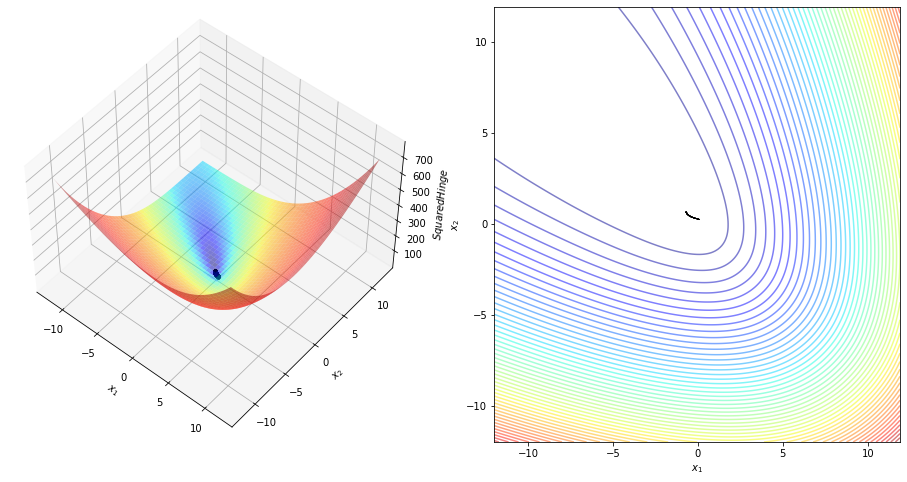

In [16]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, 
                              learning_rate=0.001, momentum=0.4, batch_size=20, early_stopping=True),
                    param_grid={'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [17]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svc_squared_hinge_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
custom_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.311301     738        0.944937      0.949796   
           standard  0.212955     575        0.949968      0.949872   
           nesterov  0.347608     647        0.952456      0.944821   
       10  none      0.119227     311        0.949950      0.949796   
           standard  0.084966     183        0.952437      0.949796   
           nesterov  0.091229     192        0.952456      0.949796   
       100 none      0.094943     167        0.952437      0.944821   
           standard  0.047192      99        0.952437      0.949796   
           nesterov  0.045644     111        0.957450      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              41        23  
           standard          31        16  
           nesterov          36        19  
       10  none              22        12  
           standard          22        12  
           nesterov          22        12  
       100 none              16         9  
           standard          14         8  
           nesterov          15         7

In [18]:
X, y = generate_linearly_separable_overlap_data(random_state=2)

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [19]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.004304     483        0.954925      0.949796   
          10  -         0.006314    1000        0.957412      0.954772   
          100 -         0.008837    1000        0.949968      0.939997   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 25        14  
          10  -                 24        13  
          100 -                 33        22

In [20]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.311301     738        0.944937      0.949796   
              standard  0.212955     575        0.949968      0.949872   
              nesterov  0.347608     647        0.952456      0.944821   
          10  none      0.119227     311        0.949950      0.949796   
              standard  0.084966     183        0.952437      0.949796   
              nesterov  0.091229     192        0.952456      0.949796   
          100 none      0.094943     167        0.952437      0.944821   
              standard  0.047192      99        0.952437      0.949796   
              nesterov  0.045644     111        0.957450      0.944821   
liblinear 1   -         0.004304     483        0.954925      0.949796   
          10  -         0.006314    1000        0.957412      0.954772   
          100 -         0.008837    1000        0.949968      0.939997   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              41        23  
              standard          31        16  
              nesterov          36        19  
          10  none              22        12  
              standard          22        12  
              nesterov          22        12  
          100 none              16         9  
              standard          14         8  
              nesterov          15         7  
liblinear 1   -                 25        14  
          10  -                 24        13  
          100 -                 33        22